In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf

import os

os.chdir('../../')

In [2]:
EPS = 1e-16

# normalizing flow layer architecture
flow_type = 'PlanarFlow'
# number of layers
K = 10
nlayers = 10
sigma0 = 0.1
s = 60

dirstr = 'V1Circuit'

behavior_type = "difference"
fac = 10.0

param_dict = {
    "behavior_type":behavior_type
    "s":s,
    "fac":fac,
}
system = get_system_from_template("V1Circuit", param_dict)

arch_dict = {'D':system.D, \
             'K':K, \
             'flow_type':flow_type, \
             'sigma0':sigma0, \
             'repeats':nlayers, \
             'post_affine':True}


lr_order = -3

{'type': 'difference', 'c_vals': array([1.]), 's_vals': array([60]), 'r_vals': array([0., 1.]), 'fac': 10.0}


In [3]:
print(system.mu)

[0.0251065  0.04960956 0.07151498 0.01784181 0.00064484 0.00247898
 0.00515613 0.0004019 ]


al final
[array(825)]


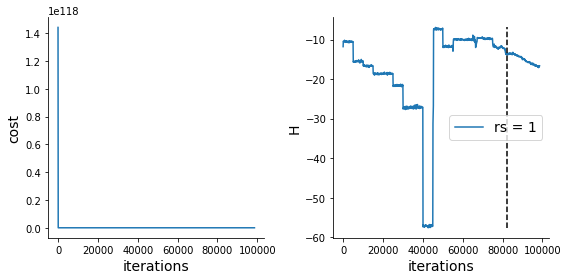

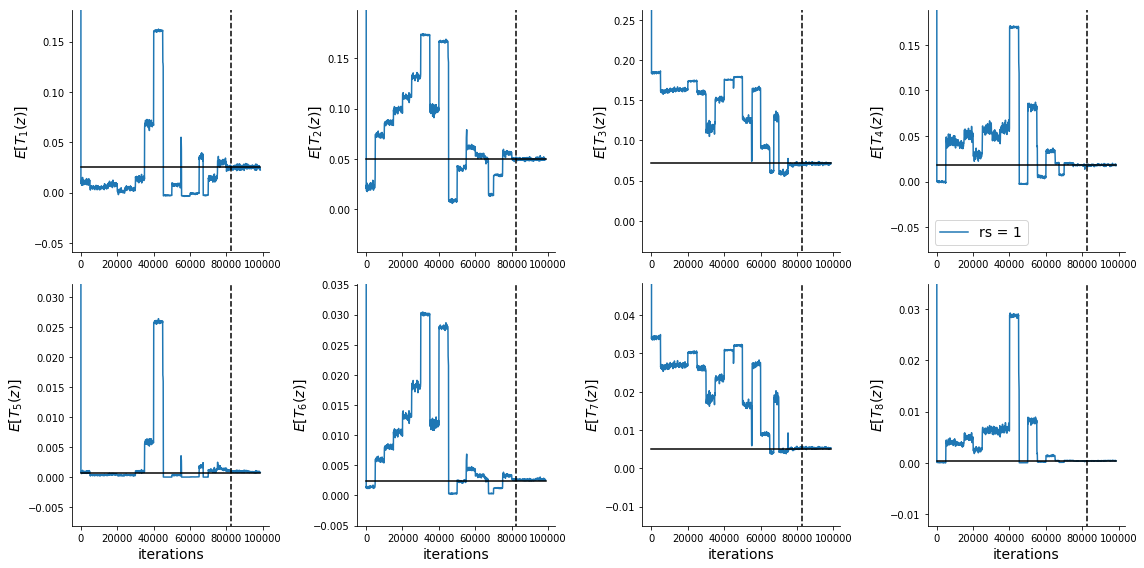

In [4]:
# multivariate normal initialization variance
sigma_init = 1.0
c_init_order = 0

start_rs = 1
num_rs = 1
random_seeds = np.arange(start_rs, num_rs+start_rs)

basedir = '/Users/sbittner/Documents/dsn/dsn/'
model_dirs = []
legendstrs = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    model_dirs.append(dsndir)
    legendstrs.append('rs = %d' % random_seed)
    
alpha = 0.05
frac_samps = 0.5
    
figs, AL_final_its, p_values = plot_opt(model_dirs, legendstrs, con_method='1', frac_samps=frac_samps, maxconlim=0.2)


In [5]:
print(system.mu)

[0.0251065  0.04960956 0.07151498 0.01784181 0.00064484 0.00247898
 0.00515613 0.0004019 ]


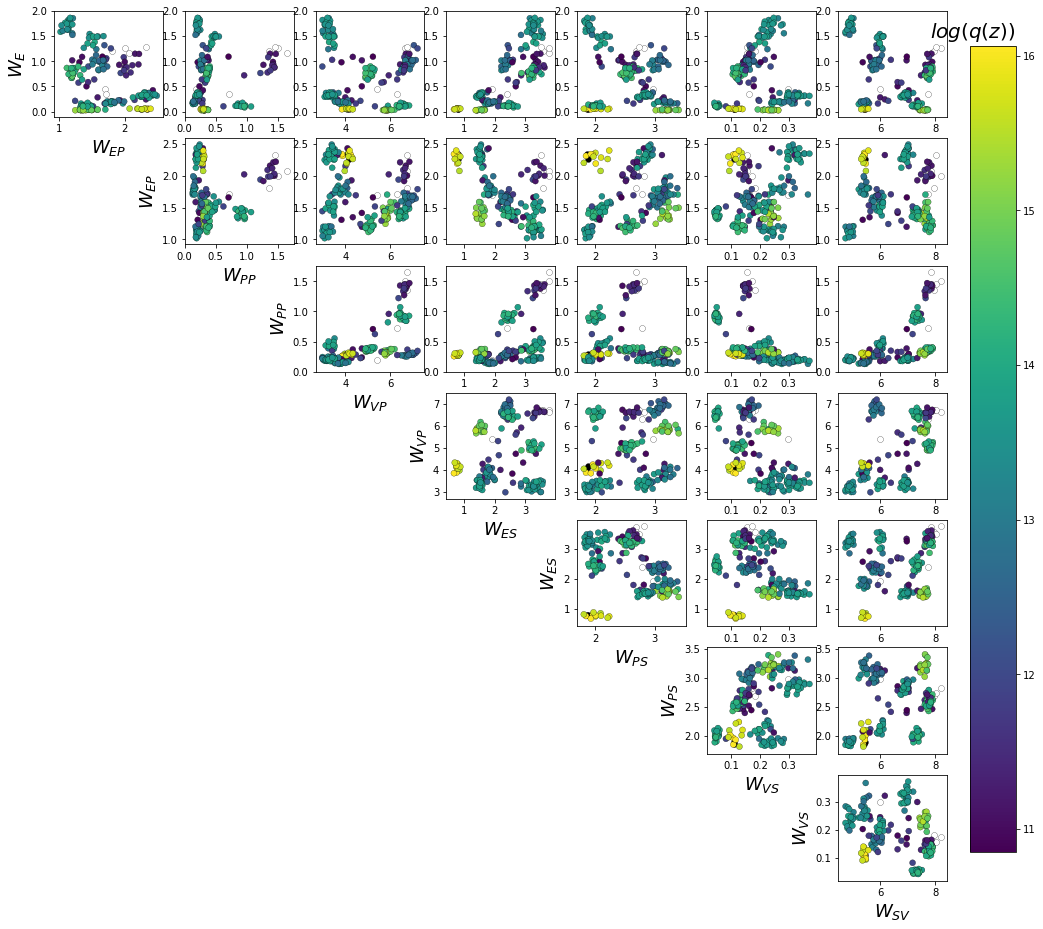

In [7]:
#pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
pfnames = ['z.png']
dists = dsn_pairplots(model_dirs, 'Zs', system, system.D, f_str='identity', \
                      c_str='log_q_z', legendstrs=[], AL_final_its=AL_final_its, \
                      xlims=None, ylims=None, \
                      fontsize=18, ellipses=False, tri=True,
                      figsize=(16,16), pfnames=pfnames)


In [8]:
_Z = dists[0]
M = _Z.shape[0]
Z = tf.placeholder(tf.float64, (1, M, system.D))
r_t = system.simulate(Z)
W, b, h_FF, h_LAT, h_RUN, tau, n, s_0, a, c_50 = system.filter_Z(Z)

In [12]:
with tf.Session() as sess:
    _r_t, _W, _b, _h_RUN = sess.run([r_t, W, b, h_RUN], {Z:np.expand_dims(_Z, 0)})

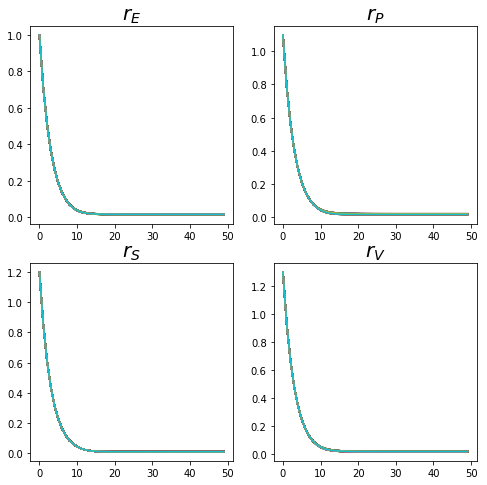

In [14]:
fontsize = 20
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].plot(_r_t[:,0, :, 0, 0])
axs[0,0].set_title(r'$r_E$', fontsize=fontsize)
axs[0,1].plot(_r_t[:,0, :, 1, 0])
axs[0,1].set_title(r'$r_P$', fontsize=fontsize)
axs[1,0].plot(_r_t[:,0, :, 2, 0])
axs[1,0].set_title(r'$r_S$', fontsize=fontsize)
axs[1,1].plot(_r_t[:,0, :, 3, 0])
axs[1,1].set_title(r'$r_V$', fontsize=fontsize)
plt.show()

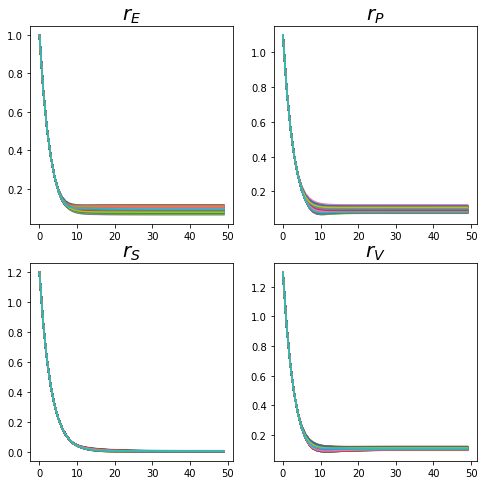

In [15]:
fontsize = 20
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].plot(_r_t[:,1, :, 0, 0])
axs[0,0].set_title(r'$r_E$', fontsize=fontsize)
axs[0,1].plot(_r_t[:,1, :, 1, 0])
axs[0,1].set_title(r'$r_P$', fontsize=fontsize)
axs[1,0].plot(_r_t[:,1, :, 2, 0])
axs[1,0].set_title(r'$r_S$', fontsize=fontsize)
axs[1,1].plot(_r_t[:,1, :, 3, 0])
axs[1,1].set_title(r'$r_V$', fontsize=fontsize)
plt.show()

In [21]:
print(_r_t.shape)
print(_b.shape, _h_RUN.shape)

(50, 2, 200, 4, 1)
(1, 200, 4, 1) (1, 200, 4, 1)


(2, 200, 4, 4) (4, 200, 50)


Text(0.5,1,'DSN samples')

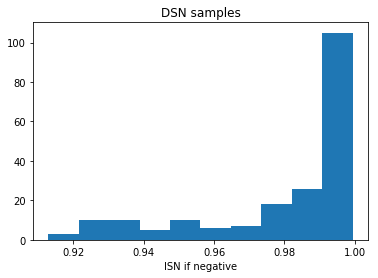

In [22]:
run = True

if (run):
    r_ss = _r_t[:,1,:,:,0].T
    print(_W.shape, r_ss.shape)
    u = np.zeros((M, 4))
    for i in range(M):
        u[i,:] = np.dot(_W[0,i,:,:], r_ss[:,i,-2]) + _h_RUN[0,i,:,0]
else:
    r_ss = _r_t[-1,0,:,:,0].T
    print(_W.shape, r_ss.shape)
    u = np.zeros((M, 4))
    for i in range(M):
        u[i,:] = np.dot(_W[0,i,:,:], r_ss[:,i,-2]) + _b[0,i,:,0]
r_ss = r_ss[:,:,-1]

uE = u[:,0].copy()
uE[uE < 0] = 0.0

plt.hist(1-2*u0*_Z[:,0])
plt.xlabel('ISN if negative')
plt.title('DSN samples')

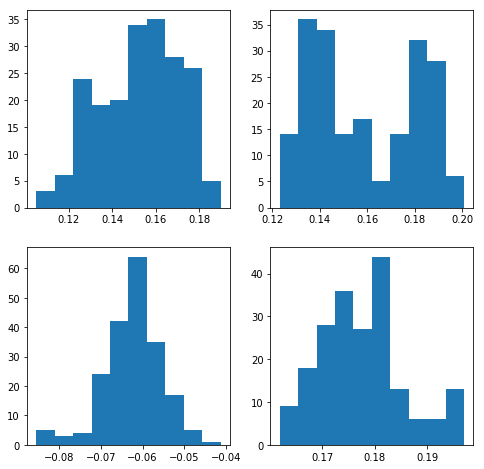

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0][0].hist(u[:,0])
axs[0][1].hist(u[:,1])
axs[1][0].hist(u[:,2])
axs[1][1].hist(u[:,3])

plt.show()